In [1]:
## headings
"""
made by weiyw @ 2019-04-08
made to test training results, using both three components in segy data
"""
import os
import time
import struct
import segyio
import argparse
import numpy as np

from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

import keras
from keras.models import Model
from keras.layers import Conv2D
from keras.layers.normalization import BatchNormalization
from keras.layers import (Input, Activation, merge, Dense, Reshape)
import metrics as metrics

# os.environ["CUDA_VISIBLE_DEVICES"]="0" 
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)


Using TensorFlow backend.


In [2]:
class Dataloader():
    def __init__(self, data_path, nt, nr, nph):
        self.data_path = data_path
        self.nt = nt
        self.nr = nr
        self.nph = nph

    def load_batch(self, batch_size=1, is_testing=False, ratio=0.5):        
        self.n_batches = int( 151 / batch_size * ratio ) #int( len(path) / batch_size * ratio )
        x_data = np.empty((batch_size, self.nt, self.nr, self.nph)) ## b-2001-467-4, acc
        y_data = np.empty((batch_size, self.nt, self.nr, 1)) ## b-2001-467-1, div, curl
        i = 0
        with segyio.open(self.data_path,'r',ignore_geometry=True) as segyfile: 
            segyfile.mmap()
            while True:
#             for i in range(self.n_batches):
                if (i + 1) * batch_size > 151 * ratio:
                    i = 0
#                     break
                for batch_i in range(batch_size):
                    for nr_i in range(self.nr):
#                     with segyio.open(self.data_path,'r',ignore_geometry=True) as segyfile:      
                        y_data[batch_i,:,nr_i,0] = \
                        segyfile.trace[i*batch_size*4*self.nr + batch_i * 4 * self.nr + nr_i * 4 + 0]
                        x_data[batch_i,:,nr_i,0] = \
                        segyfile.trace[i*batch_size*4*self.nr + batch_i * 4 * self.nr + nr_i * 4 + 1]
                        x_data[batch_i,:,nr_i,1] = \
                        segyfile.trace[i*batch_size*4*self.nr + batch_i * 4 * self.nr + nr_i * 4 + 2]
                        x_data[batch_i,:,nr_i,2] = \
                        segyfile.trace[i*batch_size*4*self.nr + batch_i * 4 * self.nr + nr_i * 4 + 3]                 
                yield x_data, y_data
                i = i + 1


In [3]:
def simpleNet(nt, nr, nph):
    x_input = Input( shape=( nt, nr, nph) )##one_piece
#     conv1 = Conv2D(
#         nb_filter=64, nb_row=3, nb_col=3, padding="same", data_format="channels_last")(x_input)
    conv1 = Conv2D(filters=64, kernel_size=(3,3), strides=(1, 1), padding='same', data_format='channels_last', 
                   dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform',
                   bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, 
                   activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(x_input)
    conv1 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                               beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', 
                               moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                               beta_constraint=None, gamma_constraint=None)(conv1)
#     conv1_1 = Conv2D(
#         nb_filter=128, nb_row=3, nb_col=3, padding="same", data_format="channels_last")(conv1)
    conv1_1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='same', data_format='channels_last', 
                   dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform',
                   bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, 
                   activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(conv1)
    conv1_1 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                               beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', 
                               moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                               beta_constraint=None, gamma_constraint=None)(conv1_1)
    
    conv1_2 = Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='same', data_format='channels_last', 
                   dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform',
                   bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, 
                   activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(conv1_1)
#     conv1_2 = Conv2D(
#         nb_filter=128, nb_row=3, nb_col=3, padding="same", data_format="channels_last")(conv1_1)
    conv1_2 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                               beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', 
                               moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                               beta_constraint=None, gamma_constraint=None)(conv1_2)
#     conv1_3 = Conv2D(
#         nb_filter=128, nb_row=3, nb_col=3, padding="same", data_format="channels_last")(conv1_2)
    conv1_3 = Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='same', data_format='channels_last', 
                   dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform',
                   bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, 
                   activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(conv1_2)   
    conv1_3 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                               beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', 
                               moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                               beta_constraint=None, gamma_constraint=None)(conv1_3)
    
    conv2 = Conv2D(filters=1, kernel_size=(3,3), strides=(1, 1), padding='same', data_format='channels_last', 
                   dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform',
                   bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, 
                   activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(conv1_3)


#     conv2 = Conv2D(
#         nb_filter=1, nb_row=3, nb_col=3, padding="same", data_format="channels_last")(conv1_3)

    model = Model(inputs=x_input, outputs=conv2)
    return model


In [4]:
# data_path = "/media/wywdisk/VSPdata/data/haveinvx/layer2_haveinvx"
data_path = '/media/wywdisk/VSPdata/data/realData/SEAM_I_Walkaway_VSP/SEAM_Well1VSP_Shots23900.sgy'
out_name = 'simpleNet_training_rawdata_3c_segy-20190407-22.final'

nt = 2001     # time step
nr = 467      # receiver
ns = 151       # shot
nmodel = 1    # batch
nph = 3

TPepoches = 1
TPbatch_size = 1

model = simpleNet(nt, nr, nph)
my_data_loader = Dataloader(data_path, nt, nr, nph)

save_dir = os.path.join(os.getcwd(), 'saved_models')
model.load_weights(os.path.join(save_dir, '{}.best.h5'.format(out_name)))

In [5]:
i_shot = 0
x_test = np.empty((1, nt, nr, nph)) ## b-2001-467-4, acc
y_test = np.empty((1, nt, nr, 1)) ## b-2001-467-1, div, curl
with segyio.open(data_path,'r',ignore_geometry=True) as segyfile:
    segyfile.mmap()
    for nr_i in range(nr):
        y_test[0,:,nr_i,0] = segyfile.trace[i_shot*4*nr + nr_i * 4 + 0]
        x_test[0,:,nr_i,0] = segyfile.trace[i_shot*4*nr + nr_i * 4 + 1]
        x_test[0,:,nr_i,1] = segyfile.trace[i_shot*4*nr + nr_i * 4 + 2]
        x_test[0,:,nr_i,2] = segyfile.trace[i_shot*4*nr + nr_i * 4 + 3]

In [6]:
# ## prdiction
# # y_predict = model.predict(x_test, batch_size=None, steps=1, verbose = 1)

# predict = model.predict_generator(my_data_loader.load_batch(batch_size=TPbatch_size, is_testing=True, ratio=0.02),\
#                                   steps=1, max_queue_size=10, \
#                                   workers=1, use_multiprocessing=False, verbose=1)

In [7]:
y_predict = model.predict(x_test, batch_size=None, verbose=1, steps=None)

1/1 [==============================] - 5s 5s/step


In [8]:
## check for predicted data
a1 = y_predict
print("Information of a1 :")
print("The shape of a1   :",a1.shape)
print("The range        : ", [a1.min(),a1.max()])

Information of a1 :
The shape of a1   : (1, 2001, 467, 1)
The range        :  [-758.7377, 677.48376]


In [12]:
## check for predicted data
a1 = y_test
print("Information of a1 :")
print("The shape of a1   :",a1.shape)
print("The range        : ", [a1.min(),a1.max()])

Information of a1 :
The shape of a1   : (1, 2001, 467, 1)
The range        :  [-2232.0810546875, 4032.208251953125]


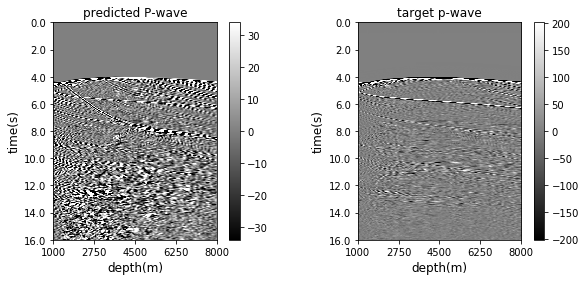

In [16]:
## plot y_predict
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
lines = 1
cols = 2
forts = 12
ss1 = 300
ss2 = 400

x_libs = [0,1000,2750,1750+2750,2*1750+2750,8000]#[0,0, 500, 1000, 1500, 2000]#np.linspace(0,1500,4)#[0, 500, 1000, 1500]
y_libs = 8 * np.linspace(0,2,9)#[0,0.4, 0.8, 1.2, 1.6, 2]

fig, axs = plt.subplots(1,2,figsize=(10, 4), sharey=True)

# obj = 'y_predict'
# im = plt.imshow(eval(obj)[0,:,:,1], extent=[0, 512, 512,0])
# plt.colorbar(im)

# ax1 = plt.subplot(131)
ax1 = plt.subplot(lines,cols,1)
obj = 'y_predict'
target_data = eval(obj)[0,:,:,0]
value_limit=np.max( target_data ) *0.05 #/ 10
# print(obj, ": ", eval(obj).shape, "\t", [eval(obj).min(), eval(obj).max()] )
im = plt.imshow(target_data, extent=[0, ss1, ss2,0],vmin=-value_limit, vmax=value_limit, cmap="gray")
plt.colorbar(im)
# plt.title("The elastic z component of VSP data", fontsize=forts);
plt.title("predicted P-wave", fontsize=forts);
plt.xlabel('depth(m)', fontsize=forts);
plt.ylabel('time(s)', fontsize=forts);
# ax1 = fig.add_subplot(131)
ax1.xaxis.set_major_locator(MultipleLocator(75))
ax1.xaxis.set(ticklabels=x_libs)#[0,300,600, 900, 1200, 1500]);
ax1.yaxis.set(ticklabels=y_libs)#[0,0.4, 0.8, 1.2, 1.6, 2]);
plt.setp(ax1.get_xticklabels(), fontsize=10);
# plt.tight_layout()

# ax1 = plt.subplot(131)
ax2 = plt.subplot(lines,cols,2)
obj = 'y_test'
target_data = eval(obj)[0,:,:,0]
value_limit=np.max( target_data ) *0.05 #/ 10
# print(obj, ": ", eval(obj).shape, "\t", [eval(obj).min(), eval(obj).max()] )
im = plt.imshow(target_data, extent=[0, ss1, ss2,0],vmin=-value_limit, vmax=value_limit, cmap="gray")
plt.colorbar(im)
# plt.title("The elastic z component of VSP data", fontsize=forts);
plt.title("target p-wave", fontsize=forts);
plt.xlabel('depth(m)', fontsize=forts);
plt.ylabel('time(s)', fontsize=forts);
# ax1 = fig.add_subplot(131)
ax2.xaxis.set_major_locator(MultipleLocator(75))
ax2.xaxis.set(ticklabels=x_libs)#[0,300,600, 900, 1200, 1500]);
ax2.yaxis.set(ticklabels=y_libs)#[0,0.4, 0.8, 1.2, 1.6, 2]);
plt.setp(ax2.get_xticklabels(), fontsize=10);
# plt.tight_layout()


